In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PyPDF2 import PdfReader
import glob


In [2]:
# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, 'rb') as f:
        pdf = PdfReader(f)
        for page_num in range(len(pdf.pages)):
            try:
                text += pdf.pages[page_num].extract_text() or ""
            except Exception as e:
                print(f"Error extracting text from page {page_num + 1} of {pdf_path}: {e}")
                continue
    return text

In [3]:
# Function to extract PDF metadata including character count and additional fields
def extract_pdf_metadata(pdf_path):
    try:
        with open(pdf_path, 'rb') as f:
            print(f"Analyzing {pdf_path}")
            pdf = PdfReader(f)
            number_of_pages = len(pdf.pages)
            text = extract_text_from_pdf(pdf_path)
            char_count = len(text)
            
            # Extracting parts from the file name
            file_name = os.path.basename(pdf_path)
            parts = file_name.split('_')
            index = parts[0]
            company = parts[1]
            year = parts[2].split('.')[0]
            
            return {
                "file_name": file_name,
                "number_of_pages": number_of_pages,
                "character_count": char_count,
                "index": index,
                "company": company,
                "year": year
            }
    except Exception as e:
        print(f"Error processing file {pdf_path}: {e}")
        return None

In [4]:
# Function to extract metadata from multiple PDFs with progress indication and error handling
def extract_metadata_with_progress(pdf_files):
    metadata = []
    total_files = len(pdf_files)
    for i, pdf in enumerate(pdf_files, start=1):
        data = extract_pdf_metadata(pdf)
        if data:
            metadata.append(data)
        print(f"Pdf {i}/{total_files} analyzed")
    return pd.DataFrame(metadata)

In [5]:
# Path to PDF files
pdf_folder = "../dataset_download/dataset"
pdf_files = glob.glob(os.path.join(pdf_folder, "*.pdf"))

In [6]:
# Extract metadata with progress indication
df = extract_metadata_with_progress(pdf_files)

In [7]:

# Summary statistics
print(df.columns)
df = pd.read_csv('company_data.csv')

RangeIndex(start=0, stop=0, step=1)


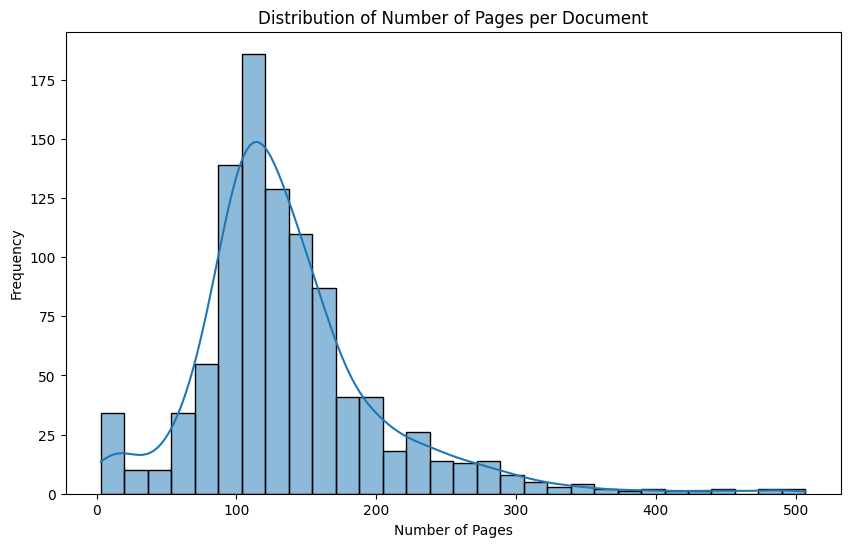

In [8]:
# Distribution of number of pages
plt.figure(figsize=(10, 6))
sns.histplot(df['number_of_pages'], bins=30, kde=True)
plt.title('Distribution of Number of Pages per Document')
plt.xlabel('Number of Pages')
plt.ylabel('Frequency')
plt.show()

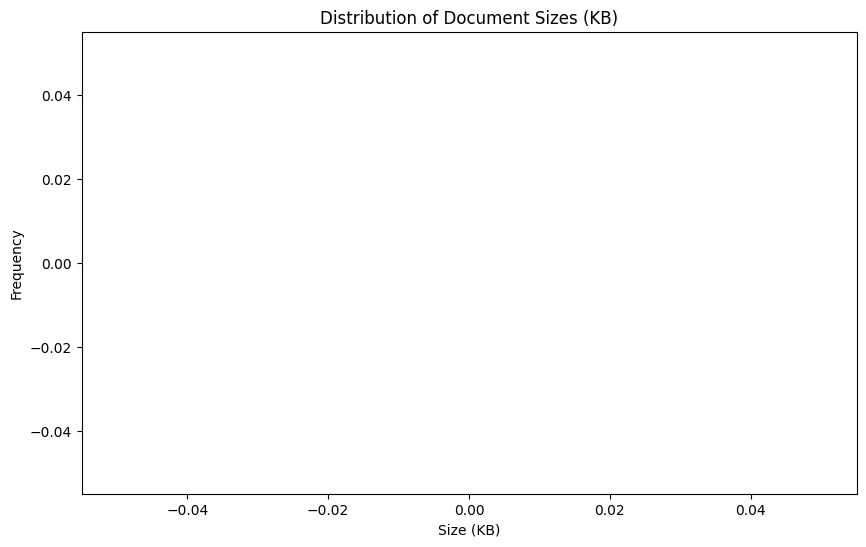

In [9]:
# Distribution of document sizes
file_sizes = [os.path.getsize(pdf) / 1024 for pdf in pdf_files]  # Sizes in KB
plt.figure(figsize=(10, 6))
sns.histplot(file_sizes, bins=30, kde=True)
plt.title('Distribution of Document Sizes (KB)')
plt.xlabel('Size (KB)')
plt.ylabel('Frequency')
plt.show()

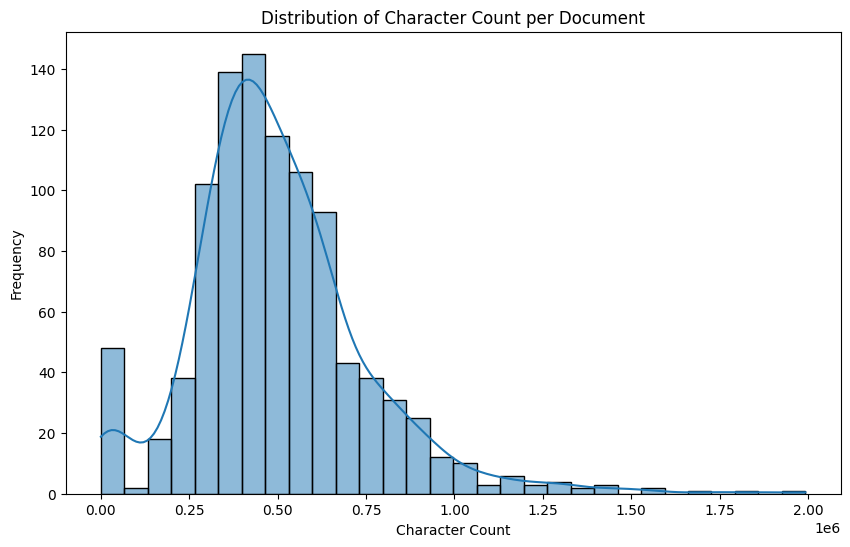

In [10]:
# Distribution of character counts
plt.figure(figsize=(10, 6))
sns.histplot(df['character_count'], bins=30, kde=True)
plt.title('Distribution of Character Count per Document')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

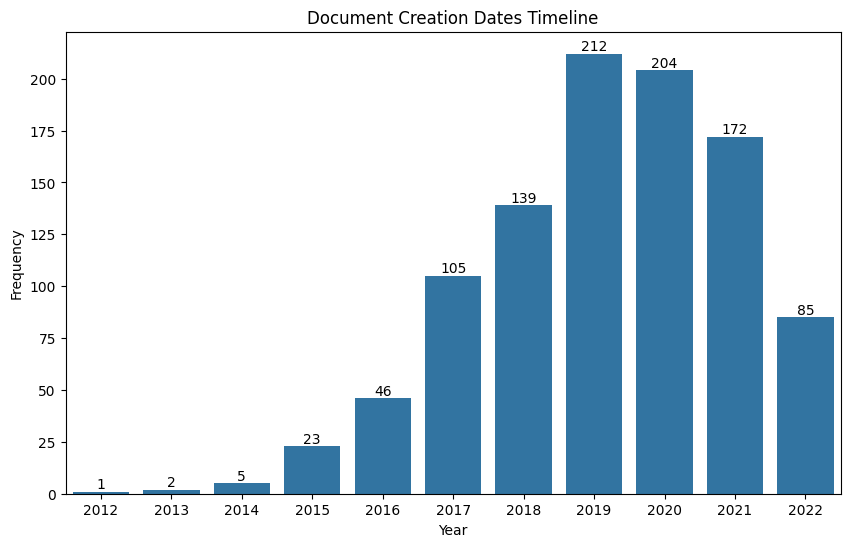

In [11]:
# Count of different years and sort by the year
year_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=year_counts.index, y=year_counts.values)
plt.title('Document Creation Dates Timeline')
plt.xlabel('Year')
plt.ylabel('Frequency')

# Adding the counts above the bars
for index, value in enumerate(year_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

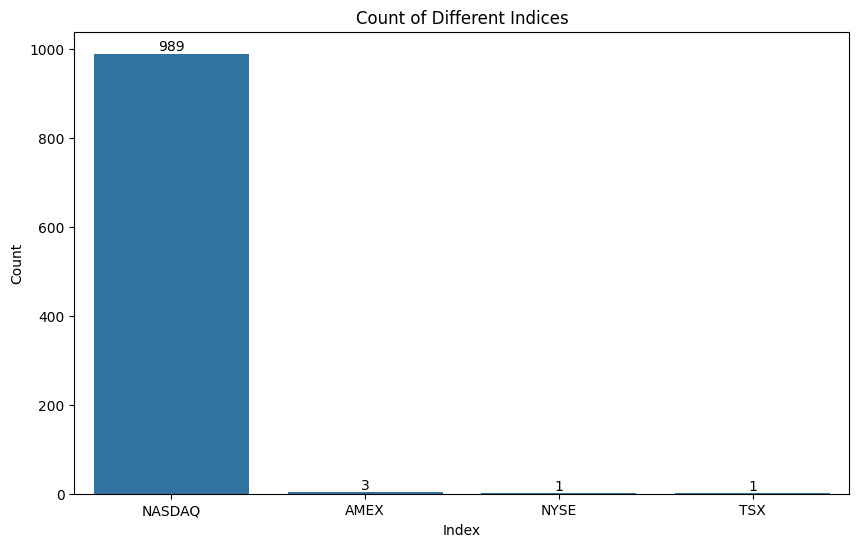

In [12]:
# Count of different indices
index_counts = df['index'].value_counts()
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=index_counts.index, y=index_counts.values)
plt.title('Count of Different Indices')
plt.xlabel('Index')
plt.ylabel('Count')

# Adding the counts above the bars
for index, value in enumerate(index_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

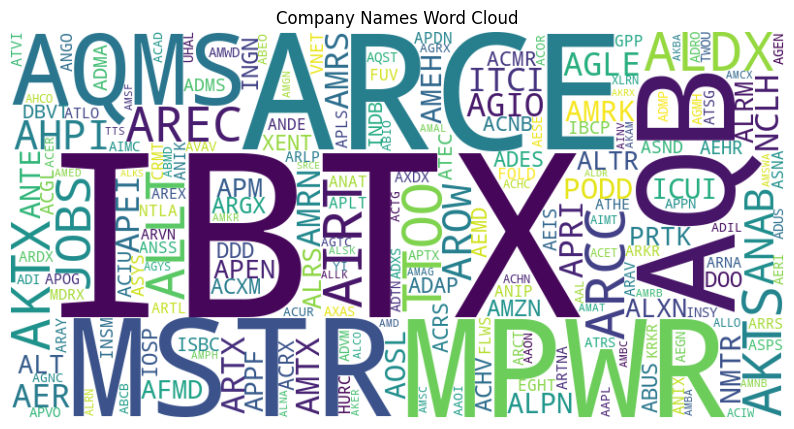

In [13]:
from wordcloud import WordCloud

# Count of different companies
company_counts = df['company'].value_counts()

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(company_counts)

# Plotting the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Company Names Word Cloud')
plt.show()



In [14]:
df.to_csv('metadata.csv', index=False)

In [15]:
import os

# Extract filenames from the pdf_files list
pdf_filenames = [os.path.basename(file) for file in pdf_files]

# Extract filenames stored in the DataFrame
df_filenames = df['file_name'].tolist()

# Find the missing filenames
missing_filenames = set(pdf_filenames) - set(df_filenames)

# List the missing filenames
missing_files = [file for file in pdf_files if os.path.basename(file) in missing_filenames]

# Print the missing files
for file in missing_files:
    print("Missing files:", (file))
print("Number of missing files:", len(missing_files))


Number of missing files: 0


In [16]:

# Function to extract metadata for encrypted PDFs
def extract_encrypted_pdf_metadata(pdf_path):
    try:
        with open(pdf_path, 'rb') as f:
            pdf = PdfReader(f)
            if pdf.is_encrypted:
                try:
                    pdf.decrypt("")
                except Exception as e:
                    print(f"Error decrypting file {pdf_path}: {e}")
                    return None
            number_of_pages = len(pdf.pages)
            text = extract_text_from_pdf(pdf_path)
            char_count = len(text)
            
            # Extracting parts from the file name
            file_name = os.path.basename(pdf_path)
            parts = file_name.split('_')
            index = parts[0]
            company = parts[1]
            year = parts[2].split('.')[0]
            
            return {
                "file_name": file_name,
                "number_of_pages": number_of_pages,
                "character_count": char_count,
                "index": index,
                "company": company,
                "year": year
            }
    except Exception as e:
        print(f"Error processing encrypted file {pdf_path}: {e}")
        return None

# Function to extract metadata from multiple PDFs with progress indication and error handling
def extract_metadata_with_progress2(pdf_files):
    metadata = []
    total_files = len(pdf_files)
    for i, pdf in enumerate(pdf_files, start=1):
        if "ACIA_2018" in pdf:
            print(f"Skipping corrupted file: {pdf}")
            continue
        if "ADBE" in pdf:
            data = extract_encrypted_pdf_metadata(pdf)
        else:
            data = extract_pdf_metadata(pdf)
        if data:
            metadata.append(data)
        print(f"Pdf {i}/{total_files} analyzed")
    return pd.DataFrame(metadata)


In [17]:
df2 = extract_metadata_with_progress2(missing_files)

In [18]:
# Get AWS credentials
AWS_ACCESS_KEY=os.getenv('AWS_ACCESS_KEY')
AWS_SECRET_KEY=os.getenv('AWS_SECRET_KEY')
AWS_BUCKET_NAME = os.getenv('AWS_BUCKET_NAME')
AWS_BUCKET_PREFIX = os.getenv('AWS_BUCKET_PREFIX')

In [19]:
import os
import boto3

# Set the custom download directory - Change to desired directory
DOWNLOAD_DIR = r'./pdfs'

# Ensure the directory exists or create it
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

# Initialize an S3 client using provided credentials
s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY
)

# List of missing filenames
missing_filenames = [
    "NASDAQ_ACIA_2018.pdf",
    "NASDAQ_ADBE_2020.pdf",
    "NASDAQ_ADBE_2021.pdf",
    "NASDAQ_ADBE_2022.pdf"
]

# List and download only the files in missing_filenames from the specified S3 bucket/prefix
response = s3.list_objects_v2(Bucket=AWS_BUCKET_NAME, Prefix=AWS_BUCKET_PREFIX)
for content in response.get('Contents', []):
    file_key = content['Key']
    file_name = file_key.split('/')[-1]
    if file_name and file_name in missing_filenames:  # Check if file is in missing_filenames
        local_path = os.path.join(DOWNLOAD_DIR, file_name)
        print(f"Downloading {file_name} to {local_path}...")
        s3.download_file(AWS_BUCKET_NAME, file_key, local_path)


In [20]:
import os
import boto3

# Set the custom download directory - Change to desired directory
DOWNLOAD_DIR = r'./pdfs'

# Ensure the directory exists or create it
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

# Initialize an S3 client using provided credentials
s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY,
    aws_secret_access_key=AWS_SECRET_KEY
)

# Prefix to filter files that start with "NASDAQ_ACIA"
FILTER_PREFIX = "NASDAQ_ACIA%20_2018"

# List and download only the files that start with FILTER_PREFIX from the specified S3 bucket/prefix
response = s3.list_objects_v2(Bucket=AWS_BUCKET_NAME, Prefix=AWS_BUCKET_PREFIX)
for content in response.get('Contents', []):
    file_key = content['Key']
    file_name = file_key.split('/')[-1]
    if file_name and file_name.startswith(FILTER_PREFIX):  # Check if file name starts with FILTER_PREFIX
        local_path = os.path.join(DOWNLOAD_DIR, file_name)
        print(f"Downloading {file_name} to {local_path}...")
        s3.download_file(AWS_BUCKET_NAME, file_key, local_path)


In [21]:
# Path to PDF files
corrupted_files = "C:\\Users\\Shaggz\\Desktop\\Programming2024\\ChatMultiplePDF\\Pdfs"
corrupted_files = glob.glob(os.path.join(pdf_folder, "*.pdf"))

df3 = extract_metadata_with_progress2(missing_files)

In [22]:
df.columns

Index(['file_name', 'number_of_pages', 'character_count', 'index', 'company',
       'year', 'Company Name'],
      dtype='object')

In [23]:
len(df.company.unique())

244

In [24]:
df.head()

,file_name,number_of_pages,character_count,index,company,year,Company Name
0,AMEX_ATRS_2012.pdf,87,344310,AMEX,ATRS,2012,"Antares Pharma, Inc."
1,AMEX_ATRS_2013.pdf,94,372759,AMEX,ATRS,2013,"Antares Pharma, Inc."
2,AMEX_ATRS_2014.pdf,95,382075,AMEX,ATRS,2014,"Antares Pharma, Inc."
3,NASDAQ_AAIC_2020.pdf,112,486596,NASDAQ,AAIC,2020,Arlington Asset Investment Corp.
4,NASDAQ_AAIC_2021.pdf,115,507554,NASDAQ,AAIC,2021,Arlington Asset Investment Corp.


In [25]:
df["character_count"].sum()/800

621843.63375

In [26]:
import pandas as pd

df = pd.read_csv("metadata.csv")
df.head()

,file_name,number_of_pages,character_count,index,company,year,Company Name
0,AMEX_ATRS_2012.pdf,87,344310,AMEX,ATRS,2012,"Antares Pharma, Inc."
1,AMEX_ATRS_2013.pdf,94,372759,AMEX,ATRS,2013,"Antares Pharma, Inc."
2,AMEX_ATRS_2014.pdf,95,382075,AMEX,ATRS,2014,"Antares Pharma, Inc."
3,NASDAQ_AAIC_2020.pdf,112,486596,NASDAQ,AAIC,2020,Arlington Asset Investment Corp.
4,NASDAQ_AAIC_2021.pdf,115,507554,NASDAQ,AAIC,2021,Arlington Asset Investment Corp.


In [27]:
df["character_count"].sum()/df["number_of_pages"].sum()

3659.5989833525823

In [28]:
df["character_count"].sum()/800

621843.63375

In [29]:
df.company.unique()

array(['ATRS', 'AAIC', 'AAL', 'AAOI', 'AAON', 'AAPL', 'ABCB', 'ABEO',
       'ABIO', 'ABMD', 'ABTX', 'ABUS', 'ACAD', 'ACER', 'ACET', 'ACGL',
       'ACHC', 'ACHN', 'ACHV', 'ACIA', 'ACIU', 'ACIW', 'ACMR', 'ACNB',
       'ACOR', 'ACRS', 'ACRX', 'ACTG', 'ACUR', 'ACXM', 'ADAP', 'ADBE',
       'ADES', 'ADIL', 'ADI', 'ADMA', 'ADMP', 'ADMS', 'ADPT', 'ADRO',
       'ADTN', 'ADUS', 'ADVM', 'ADXS', 'AEGN', 'AEHR', 'AEIS', 'AEMD',
       'AERI', 'AER', 'AESE', 'AFMD', 'AFYA', 'AGEN', 'AGFS', 'AGII',
       'AGIO', 'AGLE', 'AGMH', 'AGNC', 'AGRX', 'AGTC', 'AGYS', 'AHCO',
       'AHPI', 'AIMC', 'AIMT', 'AINV', 'AIRT', 'AKAM', 'AKBA', 'AKCA',
       'AKER', 'AKRO', 'AKRX', 'AKTS', 'AKTX', 'ALBO', 'ALCO', 'ALDR',
       'ALDX', 'ALEC', 'ALGN', 'ALGT', 'ALIM', 'ALJJ', 'ALKS', 'ALLK',
       'ALLO', 'ALLT', 'ALNA', 'ALPN', 'ALRM', 'ALRN', 'ALRS', 'ALSK',
       'ALTM', 'ALTR', 'ALT', 'ALXN', 'ALYA', 'AMAG', 'AMAL', 'AMAT',
       'AMBA', 'AMBC', 'AMCX', 'AMD', 'AMED', 'AMEH', 'AMGN', 'AMKR',
       'AMN

In [31]:
import yfinance as yf

# List of stock tickers
tickers = df.company.unique()

# Function to get company name from ticker
def get_company_name(ticker):
    try:
        stock = yf.Ticker(ticker)
        return stock.info['longName']
    except KeyError:
        return None

# Get company names for all tickers
company_names = {ticker: get_company_name(ticker) for ticker in tickers}

# Print the company names
for ticker, name in company_names.items():
    print(f"{ticker}: {name}")

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AAIC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AAIC&crumb=JYfZVUka1UB
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ACER?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ACER&crumb=JYfZVUka1UB
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ACHN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ACHN&crumb=JYfZVUka1UB
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ACRX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yaho

ATRS: None
AAIC: None
AAL: American Airlines Group Inc.
AAOI: Applied Optoelectronics, Inc.
AAON: AAON, Inc.
AAPL: Apple Inc.
ABCB: Ameris Bancorp
ABEO: Abeona Therapeutics Inc.
ABIO: ARCA biopharma, Inc.
ABMD: Abiomed, Inc.
ABTX: None
ABUS: Arbutus Biopharma Corporation
ACAD: ACADIA Pharmaceuticals Inc.
ACER: None
ACET: Adicet Bio, Inc.
ACGL: Arch Capital Group Ltd.
ACHC: Acadia Healthcare Company, Inc.
ACHN: None
ACHV: Achieve Life Sciences, Inc.
ACIA: None
ACIU: AC Immune SA
ACIW: ACI Worldwide, Inc.
ACMR: ACM Research, Inc.
ACNB: ACNB Corporation
ACOR: Acorda Therapeutics, Inc.
ACRS: Aclaris Therapeutics, Inc.
ACRX: None
ACTG: Acacia Research Corporation
ACUR: Acura Pharmaceuticals, Inc.
ACXM: Acxiom Holdings, Inc.
ADAP: Adaptimmune Therapeutics plc
ADBE: Adobe Inc.
ADES: None
ADIL: Adial Pharmaceuticals, Inc.
ADI: Analog Devices, Inc.
ADMA: ADMA Biologics, Inc.
ADMP: None
ADMS: None
ADPT: Adaptive Biotechnologies Corporation
ADRO: None
ADTN: ADTRAN Holdings, Inc.
ADUS: Addus HomeC